In [1]:
import spharpy
from spharpy.samplings import Coordinates
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colorbar import Colorbar

In [2]:
def plot_basis_functions(Y, sampling, n_max=2):
    fig = plt.figure(figsize=(12, 8))
    gs = plt.GridSpec(4, 5, height_ratios=[1, 1, 1, 0.1], width_ratios=[1, 1, 1, 1, 1])
    for acn in range(0, (n_max+1)**2):
        n, m = spharpy.spherical.acn2nm(acn)
        idx_m = np.int(np.floor(n_max/2+1)) + m
        ax = plt.subplot(gs[n, idx_m], projection='3d', aspect='equal')
        balloon = spharpy.plot.balloon(sampling, Y[:, acn], phase=True, show=False, colorbar=False)
        ax.set_title('$Y_{' + np.str(n) + '}^{' + np.str(m) + '}(\\theta, \\phi)$')
        plt.axis('off')
    cax = plt.subplot(gs[n_max+1, :])

    cb = Colorbar(ax=cax, mappable=balloon, orientation='horizontal', ticklocation='bottom')
    cb.set_label('Phase in rad')
    cb.set_ticks(np.linspace(0, 2*np.pi, 5))
    cb.set_ticklabels(['$0$', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$'])
    plt.tight_layout()

# Spherical Harmonics

The spherical harmonics can be used to describe functions on a sphere $c(\theta, \phi)$ using a set of Fourier coefficients $c_{nm}$.

$$ c(\theta, \phi) = \sum_{n=0}^N \sum_{m=-n}^n  c_{nm} {Y_n^m} (\theta, \phi)$$

$$ c_{nm} =  \int_0^{2\pi} \int_0^{\pi} c(\theta, \phi)  {Y_n^m}^*(\theta, \phi) \sin(\theta) \mathrm{d} \theta \mathrm{d} \phi $$

These two equations are also referred to as inverse spherical harmonic transform and spherical harmonic transform.

## Sampling the Sphere
For a discrete representation, the sphere needs to be sampled. The sampling points need to be chosen such that a valid approximation of the integral in the inverse spherical harmonic transform is achieved.
Samplings with this property are found in the samplings module

``` python
>>> import spharpy.samplings
```

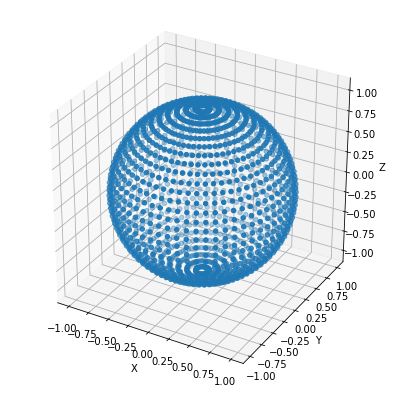

In [3]:
sampling = spharpy.samplings.gaussian(30)
plt.figure(figsize=(7, 7))
spharpy.plot.scatter(sampling)

## Complex Valued Basis Functions

In [4]:
n_max = 3
Y = spharpy.spherical.spherical_harmonic_basis(n_max, sampling)

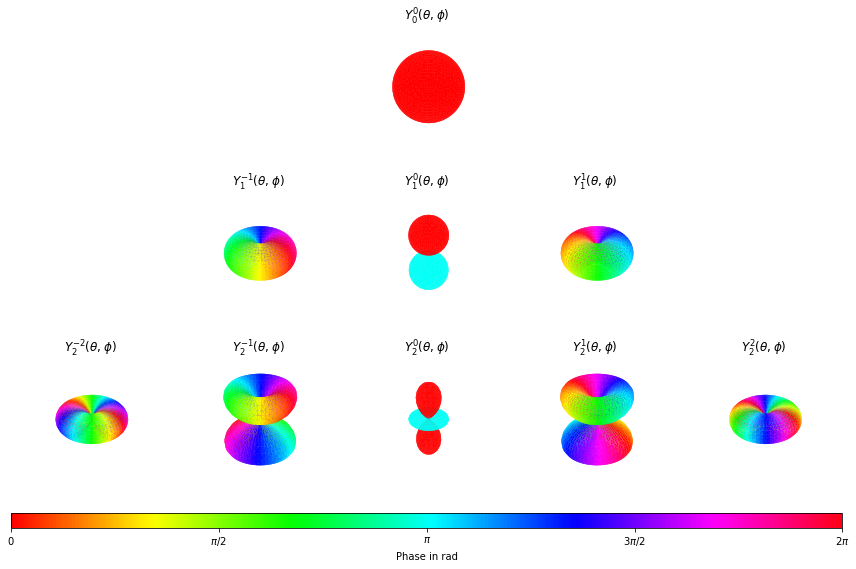

In [5]:
plot_basis_functions(Y, sampling)

## Real Valued Basis Functions

In [6]:
Y_real = spharpy.spherical.spherical_harmonic_basis_real(n_max, sampling)

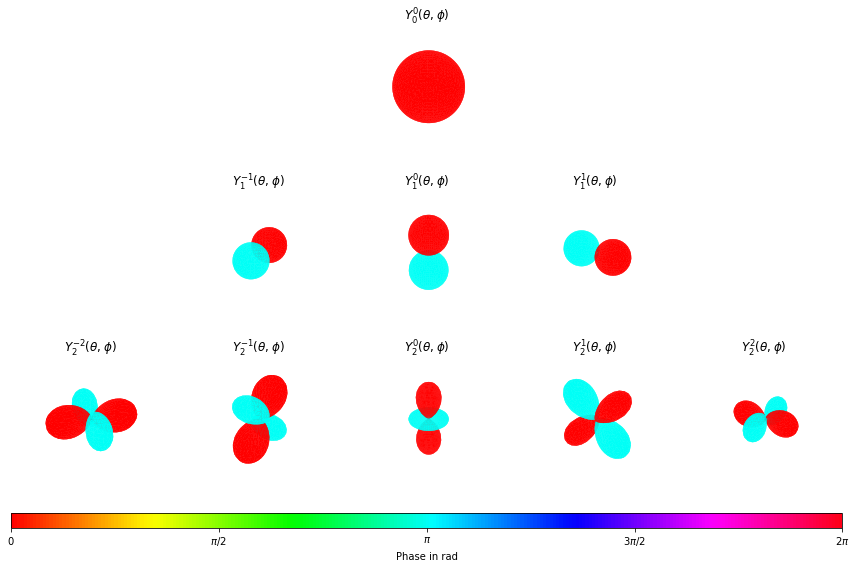

In [7]:
plot_basis_functions(Y_real, sampling)

## Spherical Harmonic Composition
Similar to the Fourier synthesis of arbitrary time signals, the superposition of spherical harmonics may be used to synthesize arbitrary functions on the sphere by weighted superposition:

$$ d(\theta, \phi) = Y_0^0(\theta, \phi) - Y_1^1(\theta, \phi)  = \mathbf{Y} \mathbf{d_{nm}}$$

with the spherical harmonic coefficient vector

$$ \mathbf{d_{nm}} = \left[ d_{0, 0}, d_{1, -1}, d_{1, 0}, d_{1, 1}, d_{2, -2}, \dots \right] = \left[ 1, 0, 0, -1, 0, \dots \right]$$

In [8]:
c_nm = np.zeros((n_max+1)**2)
c_nm[[0, 3]] = [1, -1]
c_spatial = Y_real @ c_nm

We can plot this in the spatial domain on a full unit sphere:

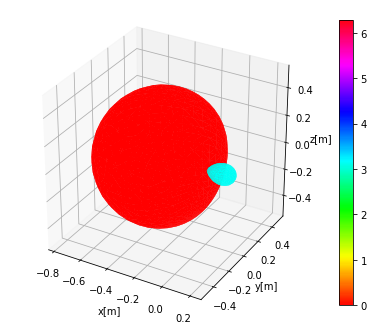

In [9]:
plt.figure(figsize=(7, 7))
spharpy.plot.balloon(sampling, c_spatial, phase=True)

However, arbitrary point sets may be used for the synthesis. Here, we plot the data on a circle in the xy-plane:

In [10]:
n_points = 128
circle = Coordinates.from_spherical(np.ones(n_points), np.full(n_points, np.pi/2), np.linspace(0, 2*np.pi, n_points))
Y_real_circle = spharpy.spherical.spherical_harmonic_basis_real(n_max, circle)

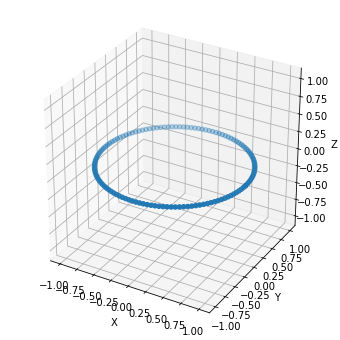

In [11]:
plt.figure(figsize=(6, 6))
spharpy.plot.scatter(circle)

In [12]:
c_spatial_circle = Y_real_circle @ c_nm

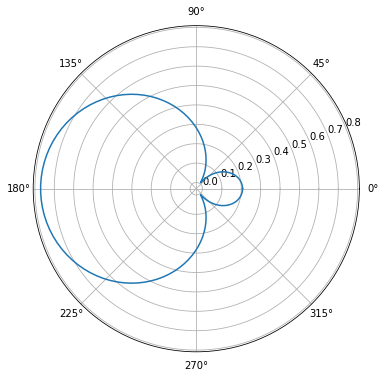

In [13]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='polar')
ax.plot(circle.azimuth, np.abs(c_spatial_circle))

## Spatial Dirac Delta Function

A perfect dirac delta function in the spatial domain may be represented by a vector pointing in only one direction $(\theta^\prime, \phi^\prime)$,

$$ \delta(\theta^\prime, \phi^\prime) = \delta(\cos(\theta - \cos\theta^\prime) \delta(\phi - \phi^\prime)$$

Using the sifting property, we can find an analytic solution in the spherical harmonic domain

$$ \delta_{nm}^{(\theta^\prime, \phi^\prime)}=  \int_0^{2\pi} \int_0^{\pi} \delta(\theta^\prime, \phi^\prime) {Y_n^m}^* (\theta, \phi) \sin(\theta) \mathrm{d} \theta \mathrm{d} \phi = {Y_n^m}^* (\theta^\prime, \phi^\prime)$$

If we now re-synthesize the spatial dirac function, we see that the spatial resoltion of our  new function is limited by the spherical harmonic order $N$.

$$ \delta(\theta^\prime, \phi^\prime) = \sum_{n=0}^N \sum_{m=-n}^n  \delta_{nm}^{(\theta^\prime, \phi^\prime)} {Y_n^m} (\theta, \phi) $$

In [14]:
c_nm_delta_x = np.squeeze(spharpy.spherical.spherical_harmonic_basis_real(n_max, Coordinates(-1, 0, 0)))
c_delta_x = Y_real @ c_nm_delta_x
c_delta_x_circle = Y_real_circle @ c_nm_delta_x

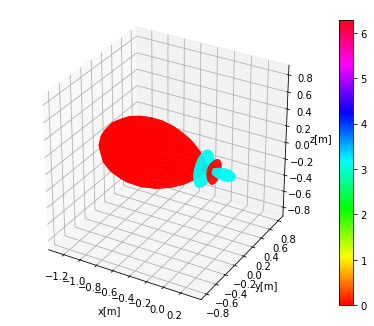

In [15]:
plt.figure(figsize=(7, 7))
spharpy.plot.balloon(sampling, c_delta_x, phase=True)

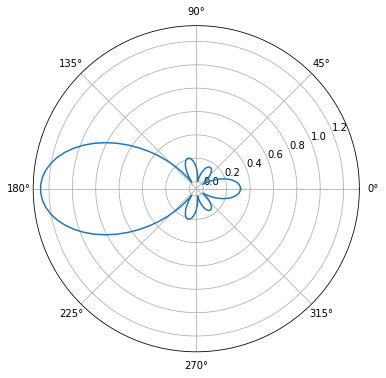

In [16]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='polar')
ax.plot(circle.azimuth, np.abs(c_delta_x_circle))

# Gradient of the Spherical Harmonics

The gradient of the spherical harmonics on the unit sphere can be written as,

$$ \vec{\nabla}{Y_n^m} (\theta, \phi) = \frac{\mathrm{d}}{\mathrm{d}\theta}{Y_n^m} (\theta, \phi) \vec{e_{\theta}} + \frac{1}{\sin(\theta)}\frac{\mathrm{d}}{\mathrm{d}\phi}{Y_n^m} (\theta, \phi) \vec{e_{\phi}}.$$

This representation may be used for the calculation of vector fields, such as the particle velocity and Intensity, in spherical coordinates.

## Gradient of the Complex-Valued Spherical Harmonics

In [17]:
n_max = 3
Y_grad_theta, Y_grad_phi = spharpy.spherical.spherical_harmonic_basis_gradient(n_max, sampling)

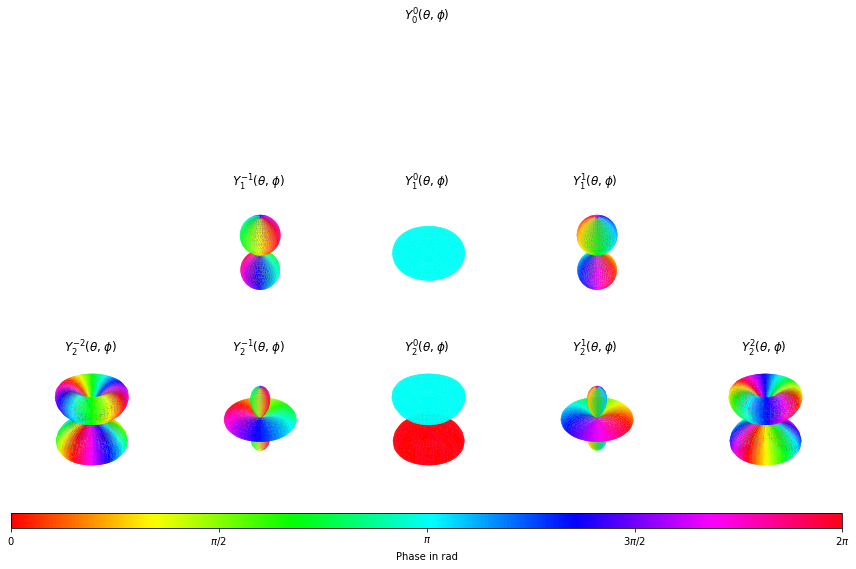

In [18]:
plot_basis_functions(Y_grad_theta, sampling)

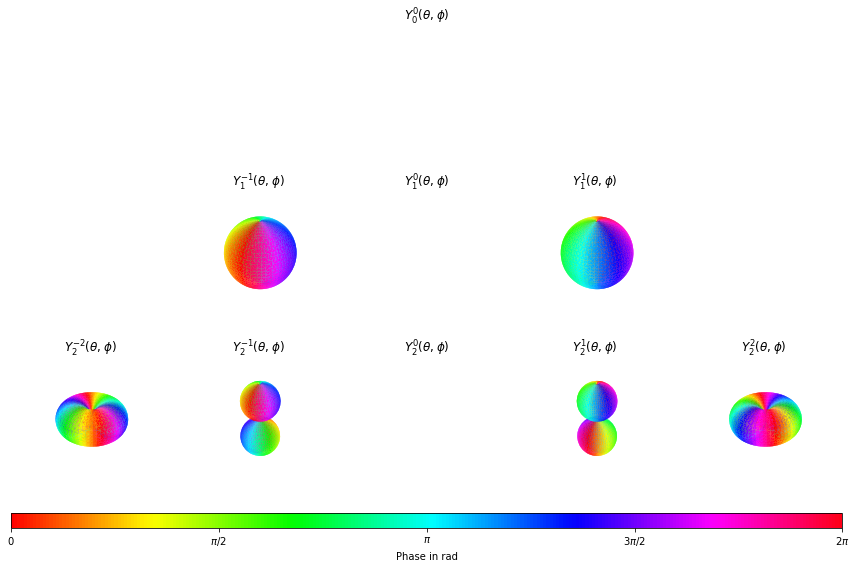

In [19]:
plot_basis_functions(Y_grad_phi, sampling)

## Gradient of the Real-Valued Spherical Harmonics

In [20]:
n_max = 3
Y_grad_theta_real, Y_grad_phi_real = spharpy.spherical.spherical_harmonic_basis_gradient_real(n_max, sampling)

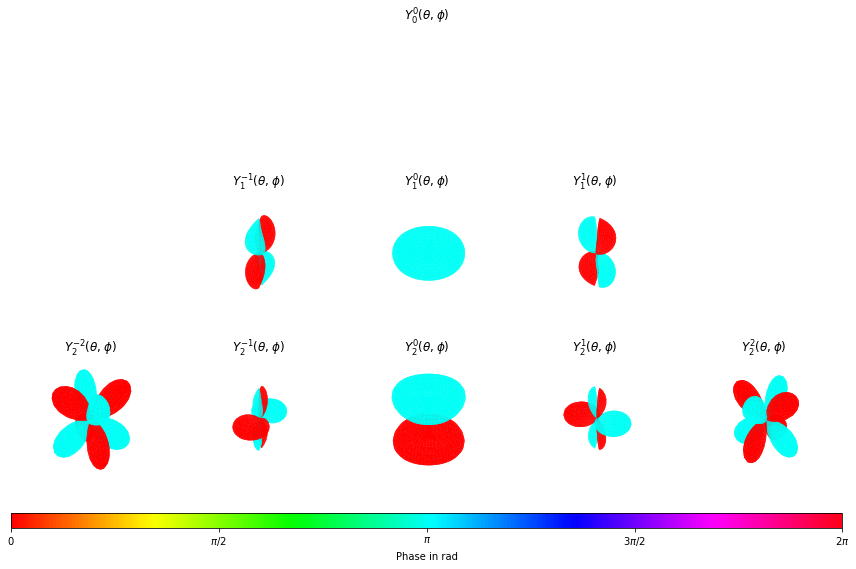

In [21]:
plot_basis_functions(Y_grad_theta_real, sampling)

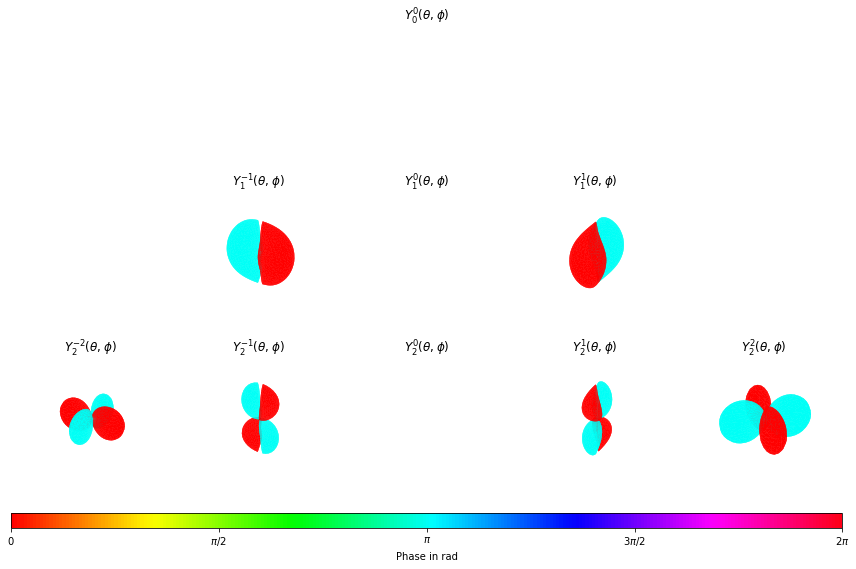

In [22]:
plot_basis_functions(Y_grad_phi_real, sampling)